#### Imports

In [1]:
import pandas as pd
from utils import *
from transformers import Trainer, EarlyStoppingCallback, TrainingArguments, AutoTokenizer, AutoModelForSequenceClassification

label_type = 'binary_label'

#### Load and Analyze Data

In [3]:
cols = ['statement', 'subject', 'speaker']
SPLITS = ['train', 'test', 'validation']
dfs = {}
for split in SPLITS:
    dfs[split] = pd.read_csv(f'data/{split}/preprocessed_liar-{split}.csv')
    dfs[split] = dfs[split].dropna(subset=cols).reset_index(drop=True)

In [ ]:
dataset = {}

for split in SPLITS:
    dataset[split] = load_data(
        data=dfs[split], 
        remove_all=True,
        label_type=label_type, 
        cols=cols)

##### Balance Data

In [5]:
trainset = balance_dataset(dataset['train'])
testset = dataset['test']
valset = dataset['validation']

##### Explore Data

In [6]:
display_samples(trainset, num_samples=3)

killed lots innocent people state texas [SEP] crime legal issues [SEP] farouk shami 1
says hillary clinton sent memo state department staff said state department business personal email [SEP] ethics transparency [SEP] joe scarborough 0
obamacare doesnt require members congress abide rules americans [SEP] health care [SEP] scott walker 1


In [80]:
from collections import Counter

def get_common_words_dataframe(df, class_label=0, top_k=10):
    statements = df.loc[df.label == class_label].statement
    text = ' '.join(statements)
    words = text.split(' ')
    word_counts = Counter(words)

    most_common_words = word_counts.most_common()
    top_words = most_common_words[:top_k]
    top_words_df = pd.DataFrame(top_words, columns=['Word', 'Count'])
    
    return top_words_df

def plot_countplot(df, ax, class_label=0):
    sns.set(style='darkgrid')
    sns.barplot(x='Count', y='Word', data=df, ax=ax)
    ax.set_title(f'Word Counts for "{mappings_inverse[class_label]}"')
    ax.set_xlabel('Count', fontsize=10)
    ax.set_ylabel('Word', fontsize=10)
    c = df.iloc[0].Count
    ax.set_xticks([i * 10 for i in range(c//10+2)])
    

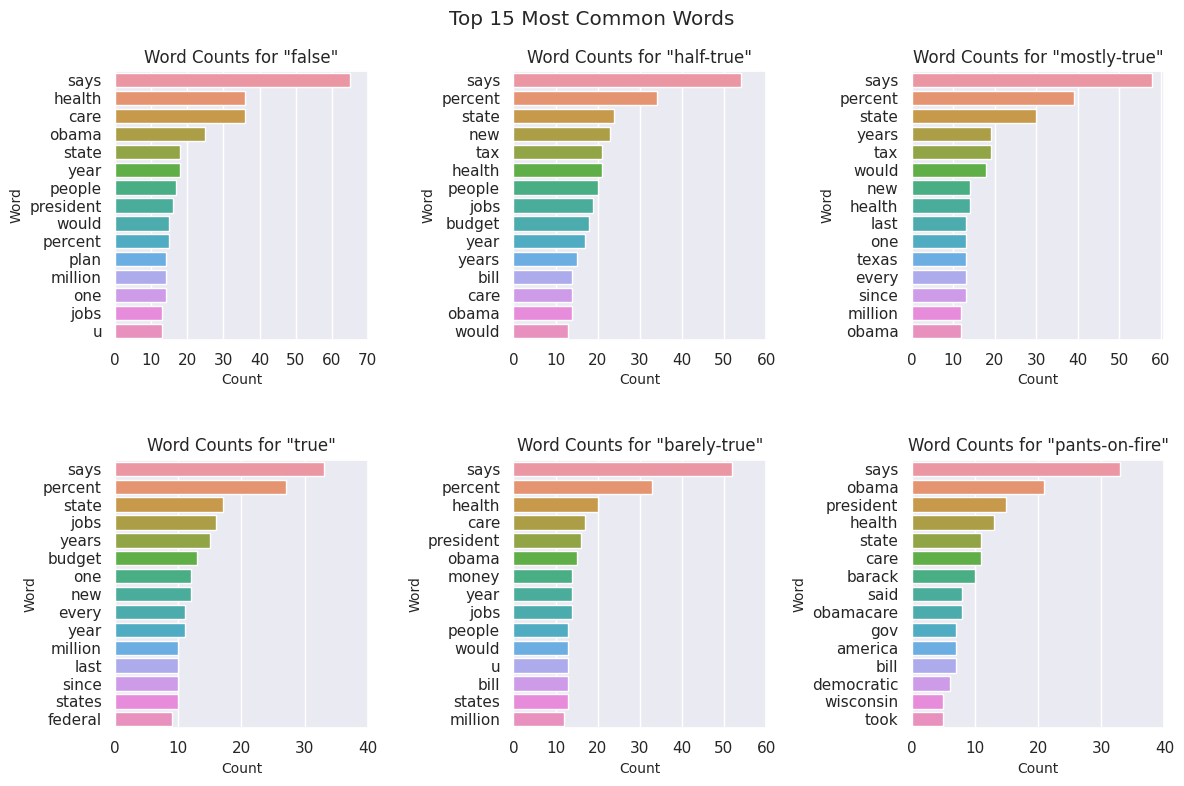

In [81]:
num_classes = 6
k = 15
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
plt.suptitle('Top {} Most Common Words'.format(k))

for i in range(num_classes):
    df = get_common_words_dataframe(dfs['validation'], class_label=i, top_k=k)
    
    col = i % 3
    row = 0 if i < 3 else 1

    plot_countplot(df, ax=axs[row][col], class_label=i)
    
    del df

plt.tight_layout(w_pad=1, h_pad=3)
plt.show()

##### Tokenize Data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
def tokenize_dataset(data):
    return tokenizer(data['text'],
                     max_length=200,
                     truncation=True,
                     padding="max_length")

train_dataset = trainset.map(tokenize_dataset)
test_dataset = testset.map(tokenize_dataset)
val_dataset = valset.map(tokenize_dataset)

#### Train Model

In [8]:
# import torch 

# # model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)
# model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=multiclass[label_type]).to(torch.device('cuda'))

# # Set up training arguments
# training_args = TrainingArguments(
#     output_dir="./sentiment_transfer_learning_transformer-binary/",
#     logging_dir='./sentiment_transfer_learning_transformer-binary/logs',
#     logging_strategy='epoch',
#     logging_steps=100,
#     num_train_epochs=10,
#     per_device_train_batch_size=128,
#     per_device_eval_batch_size=128,
#     learning_rate=5e-6,
#     seed=42,
#     save_strategy='epoch',
#     save_steps=100,
#     evaluation_strategy='epoch',
#     eval_steps=100,
#     load_best_model_at_end=True
# )

# # Train the model
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
#     compute_metrics=compute_metrics,
#     callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
# )

# trainer.train()

# evaluate_performance(trainer, test_dataset)

#### Evaluate Model

##### Load Model and Trainer

In [9]:
model_path = './App/server/trained-uncased-model'
model = AutoModelForSequenceClassification.from_pretrained(model_path)

eval_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_eval_batch_size=32,
    num_train_epochs=0,
)

trainer = Trainer(
    model=model,
    args=eval_args,
)

##### Evaluation on splits

/mnt/c/Users/chris/Desktop/Portfolio/Fake-News-Detection/utils.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(pred)


{'f1': 0.6724099688834515}
{'recall': 0.6724521584334668}
{'precision': 0.6725410430547827}


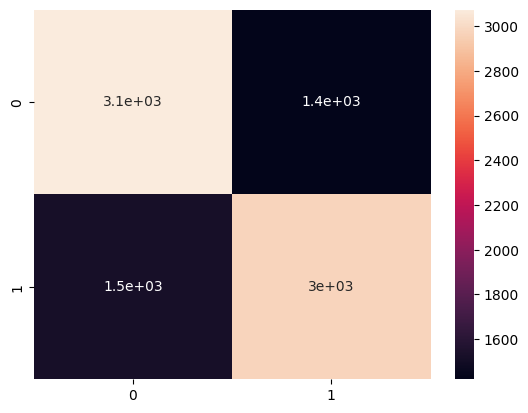

In [10]:
evaluate_performance(trainer, train_dataset)

/mnt/c/Users/chris/Desktop/Portfolio/Fake-News-Detection/utils.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(pred)


{'f1': 0.6194574490604677}
{'recall': 0.6202735198361256}
{'precision': 0.6191621198974464}


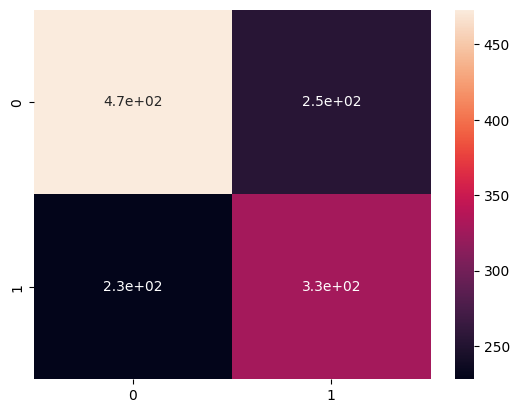

In [11]:
evaluate_performance(trainer, test_dataset)

/mnt/c/Users/chris/Desktop/Portfolio/Fake-News-Detection/utils.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(pred)


{'f1': 0.633978071240769}
{'recall': 0.6342913908899209}
{'precision': 0.6340733853852294}


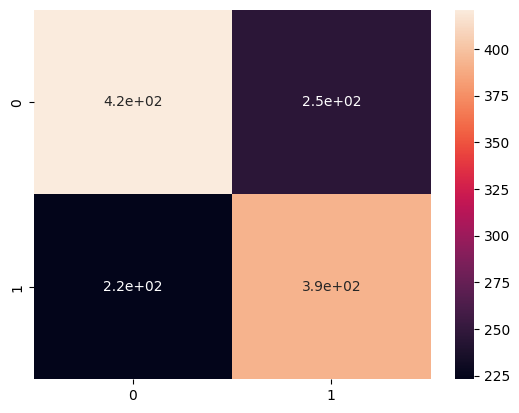

In [12]:
evaluate_performance(trainer, val_dataset)

##### ROC Curves

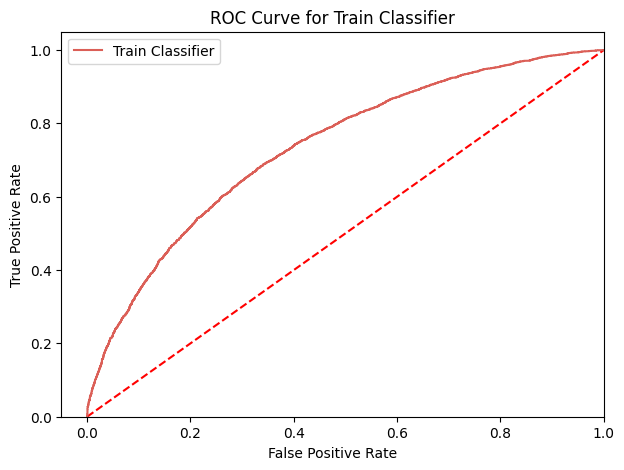

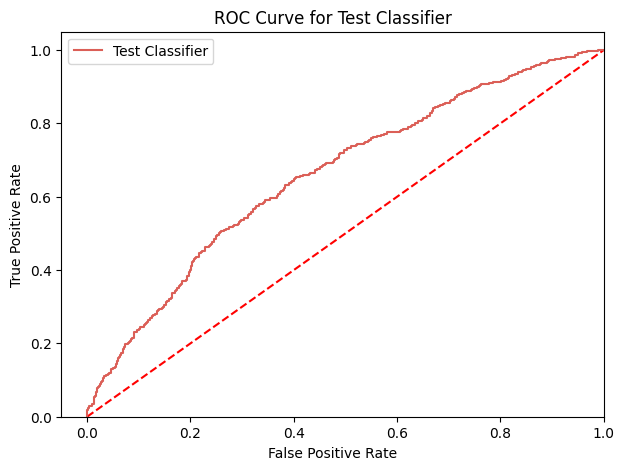

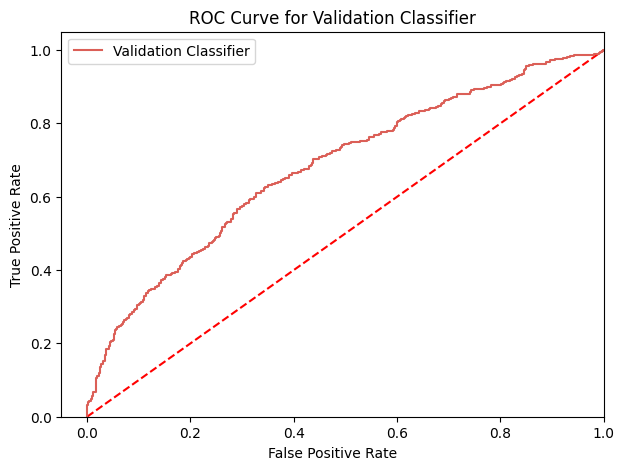

In [13]:
if label_type == 'binary_label':
    plot_roc_curves(trainer, train_dataset, label = 'Train Classifier')
    plot_roc_curves(trainer, test_dataset, label = 'Test Classifier')
    plot_roc_curves(trainer, val_dataset, label = 'Validation Classifier')

##### Column Ablation

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

/mnt/c/Users/chris/Desktop/Portfolio/Fake-News-Detection/utils.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(pred)


{'f1': 0.5718169390418194}
{'recall': 0.5885374385977743}
{'precision': 0.6107484059438246}


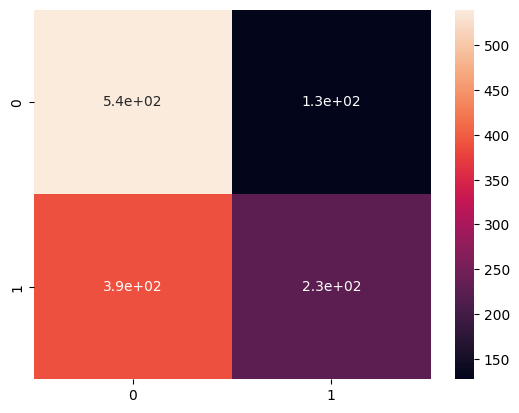

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

/mnt/c/Users/chris/Desktop/Portfolio/Fake-News-Detection/utils.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(pred)


{'f1': 0.5839122807017543}
{'recall': 0.5900171865286868}
{'precision': 0.5987267958408308}


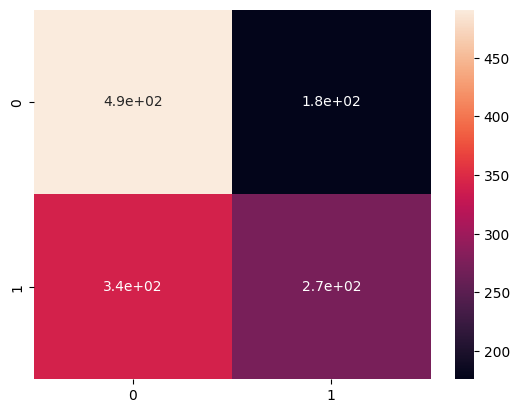

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

/mnt/c/Users/chris/Desktop/Portfolio/Fake-News-Detection/utils.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(pred)


{'f1': 0.6245900359206622}
{'recall': 0.6245243232042516}
{'precision': 0.6248054515113088}


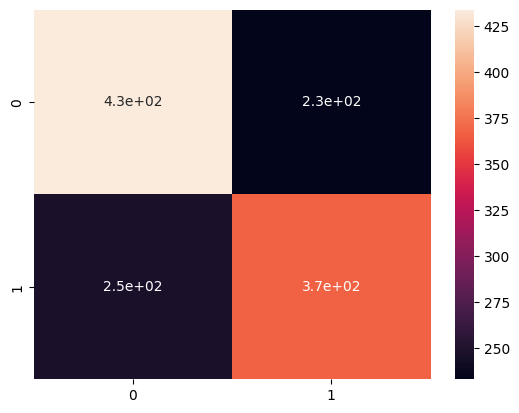

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

/mnt/c/Users/chris/Desktop/Portfolio/Fake-News-Detection/utils.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(pred)


{'f1': 0.633978071240769}
{'recall': 0.6342913908899209}
{'precision': 0.6340733853852294}


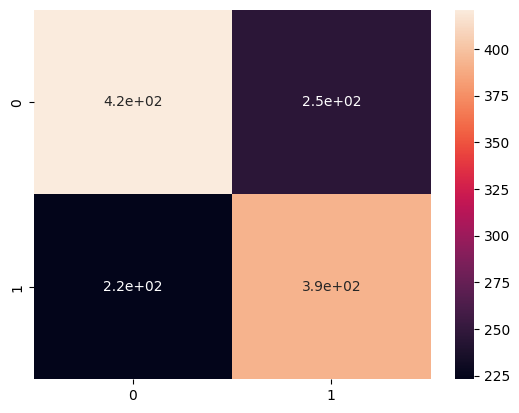

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

Map:   0%|          | 0/1282 [00:00<?, ? examples/s]

/mnt/c/Users/chris/Desktop/Portfolio/Fake-News-Detection/utils.py:161: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_proba = softmax(pred)


{'f1': 0.636378022919776}
{'recall': 0.6367937982228398}
{'precision': 0.636570068414635}


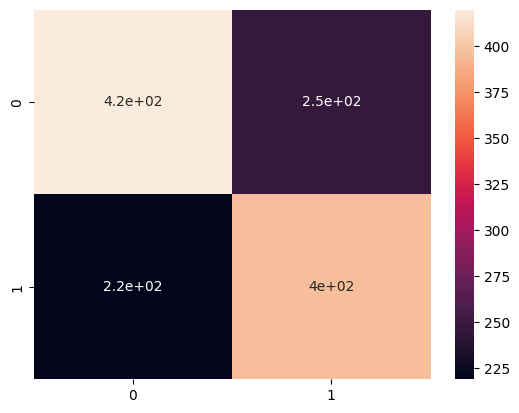

In [14]:
cols_set = [
    ['statement'],
    ['statement', 'subject'],
    ['statement', 'speaker'],
    ['statement', 'subject', 'speaker'],
    ['statement', 'speaker', 'subject']
]

for cols in cols_set:
    dataset = {}
    dataset['validation'] = load_data(
        data=dfs['validation'], 
        remove_all=True,
        label_type=label_type, 
        cols=cols)
    val_dataset = dataset['validation'].map(tokenize_dataset)
    evaluate_performance(trainer, val_dataset)